# 75.06/95.58 Organización de Datos
# Primer Cuatrimestre de 2020
# Trabajo Práctico 2: Enunciado


El segundo TP es una competencia de Machine Learning en donde cada grupo debe intentar determinar, para cada tweet brindado, si el mismo esta basado en un hecho real o no.

La competencia se desarrolla en la plataforma de Kaggle  https://www.kaggle.com/c/nlp-getting-started.  

El dataset consta de una serie de tweets, para los cuales se informa:

- id - identificador unico para cada  tweet
- text - el texto del tweet
- location - ubicación desde donde fue enviado (podría no estar)
- keyword - un keyword para el tweet  (podría faltar)
- target - en train.csv, indica si se trata de un desastre real  (1) o no (0)
 


Los submits con el resultado deben tener el formato:

Id: Un id numérico para identificar el tweet
target: 1 / 0 según se crea que el tweet se trata sobre un desastre real, o no.

Los grupos deberán probar distintos algoritmos de Machine Learning para intentar predecir si el tweet está basado en hechos reales o no. A medida que los grupos realicen pruebas deben realizar el correspondiente submit en Kaggle para evaluar el resultado de los mismos.

Al finalizar la competencia el grupo que mejor resultado tenga obtendrá 10 puntos para cada uno de sus integrantes que podrán ser usados en el examen por promoción o segundo recuperatorio.

## Requisitos para la entrega del TP2:

- El TP debe programarse en Python o R.
- Debe entregarse un pdf con el informe de algoritmos probados, algoritmo final utilizado, transformaciones realizadas a los datos, feature engineering, etc. 
- El informe debe incluir también un link a github con el informe presentado en pdf, y todo el código.
- El grupo debe presentar el TP en una computadora en la fecha indicada por la cátedra, el TP debe correr en un lapso de tiempo razonable (inferior a 1 hora) y generar un submission válido que iguale el mejor resultado obtenido por el grupo en Kaggle. (mas detalles a definir)

## El TP2 se va a evaluar en función del siguiente criterio:

- Cantidad de trabajo (esfuerzo) del grupo: ¿Probaron muchos algoritmos? ¿Hicieron un buen trabajo de pre-procesamiento de los datos y feature engineering?
- Resultado obtenido en Kaggle (obviamente cuanto mejor resultado mejor nota)
- Presentación final del informe, calidad de la redacción, uso de información obtenida en el TP1, conclusiones presentadas.
- Performance de la solución final.

## Forma de evaluar kaggle

Las presentaciones se evalúan utilizando F1 entre las respuestas previstas y esperadas.

F1 se calcula de la siguiente manera:
$ F1=(2∗precision∗recall)/(precision+recall) $

donde:

$precision=TP/(TP+FP)$

$recall=TP/(TP+FN)$


con:

- Verdadero positivo [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
- Falso positivo [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
- Falso Negativo [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

importaciones

In [1]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

#plt.style.use('default')

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format 

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
#librerias para KNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#red neuronal
from keras.models import Sequential
from keras.layers.core import Dense
#arboles de decicion
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#catboost
from catboost import CatBoostRegressor

#palabras
import nltk
#nltk.download('stopwords')#si no tiene stopword habilitar esta linea
from nltk.corpus import stopwords
import gensim 
from gensim.models import Word2Vec 
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

/home/francisco/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [2]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stopwordEnglis = stopwords.words('english')
#tfidf = TfidfVectorizer()

inicio de csv

In [3]:
tweets_original_entrenamiento = pd.read_csv('train.csv',index_col=['id'])
tweets_original_entrenamiento.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_original_prueba = pd.read_csv('test.csv',index_col=['id'])
tweets_original_prueba.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


calculo resultado

In [5]:
#resultados
resultados_de_test = pd.read_csv('respuestas.csv',index_col=['id'])
#revisar los resultados
def calclarPresicionYRecall(df):
    respuestas = resultados_de_test
    respuestas['prediccion'] = df['target']
    #respuestas['TP'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FP'] = [1 if (respuestas['target'] == 0 and respuestas['prediccion'] == 1) else 0]
    #respuestas['FN'] = [1 if (respuestas['target'] == 1 and respuestas['prediccion'] == 0) else 0]
    
    respuestas.loc[respuestas['prediccion'] + respuestas['target'] == 2 , 'TP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 1 , 'FP'] = 1
    respuestas.loc[respuestas['prediccion'] + (respuestas['target'] * 2) == 2 , 'FN'] = 1
    respuestas['TP'].fillna(0, inplace=True)
    respuestas['FP'].fillna(0, inplace=True)
    respuestas['FN'].fillna(0, inplace=True)

    tp = respuestas['TP'].sum()
    fp = respuestas['FP'].sum()
    fn = respuestas['FN'].sum()
    
    #print(tp,fp,fn)
    #print(respuestas.head())
    
    sumaPresicion = tp + fp
    sumaRecall = tp + fn
    presicion = tp / sumaPresicion
    recall = tp / sumaRecall
    return (presicion,recall)

def F1(df):
    presicion,recall = calclarPresicionYRecall(df)
    resultado = 2 * presicion * recall
    resultado /= (presicion + recall)
    return resultado

inicio de problema

## CATBOOST

In [6]:
"""
vacio = 0000
a = 0001
b = 0010
c = 0011
d = 0100
e = 0101
f = 0110
h = 0111
r = 1000
s = 1001
t = 1010
w = 1011
"""
LETRAS_0 = ['a','c','e','h','s','w']
def letra0(x):
    if (x in LETRAS_0):
        return 1
    return 0
LETRAS_1 = ['b','c','f','h','t','w']
def letra1(x):
    if (x in LETRAS_1):
        return 1
    return 0
LETRAS_2 = ['d','e','f','h']
def letra2(x):
    if (x in LETRAS_2):
        return 1
    return 0
LETRAS_3 = ['r','s','t','w']
def letra3(x):
    if (x in LETRAS_3):
        return 1
    return 0
def letra_inicial_Keyword_BOW(df):
    #for i in range(0,4):
    #    texto = 'letra_' + str(i)
    #    df[texto] = 0
    df['letra_0'] = 0
    df['letra_1'] = 0
    df['letra_2'] = 0
    df['letra_3'] = 0
    df['letra_0'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_1'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_2'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    df['letra_3'] = df['keyword'].str.strip().str[0].map(lambda x:letra0(x))
    return df
     

In [7]:

def set_palabras_del_train(df):
    palabrasTexto = []
    palabrasKeyword = []
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    return (palabrasTexto,palabrasKeyword)

def preparar_df(df,listadoDePalabrasDelTextoDelSetDeEntrenamiento=[],listadoDePalabrasDelKeywordDelSetDeEntrenamiento=[]):
    df['text'].fillna("", inplace=True)
    df['keyword'].fillna("", inplace=True)
    df['location'].fillna("", inplace=True)
    
    df['longitud_de_texto'] = df['text'].str.len()
    df['longitud_de_keyword'] = df['keyword'].str.len()
    
    df['palabras_de_texto'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    df['palabras_de_keyword'] = df['text'].str.lower().str.split().apply(lambda x: [item for item in x if item not in stopwordEnglis])
    
    df['cantidad_de_palabras_texto'] = df['palabras_de_texto'].map(len)
    df['cantidad_de_palabras_keyword'] = df['palabras_de_keyword'].map(len)
    
    #df['palabras_de_texto'] = df['palabras_de_texto'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelTextoDelSetDeEntrenamiento])
    #df['palabras_de_keyword'] = df['palabras_de_keyword'].apply(lambda x: [item for item in x if item in listadoDePalabrasDelKeywordDelSetDeEntrenamiento])
    
    #df['text'] = df['text'].str.replace(r' ', '')
    #df['keyword'] = df['keyword'].str.replace(r' ', '')
    #df['location'] = df['location'].str.replace(r' ', '')
    
    #TF-IDF
    #x = tfidf.fit_transform(df['palabras_de_texto'])
    #df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    #df.join(df_tfidf)#mal planteado
    
    df = letra_inicial_Keyword_BOW(df)   
    df = df.drop(columns=['keyword','text','location'])
    df = df.drop(columns=['palabras_de_texto','palabras_de_keyword'])
    
    return df

In [8]:
train_label = tweets_original_entrenamiento['target']
train_set = tweets_original_entrenamiento
train_set = train_set.drop(columns=['target'])
train_set = preparar_df(train_set)
train_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,letra_0,letra_1,letra_2,letra_3
id,,,,,,,,
1,69,0,7,7,0,0,0,0
4,38,0,7,7,0,0,0,0
5,133,0,11,11,0,0,0,0
6,65,0,7,7,0,0,0,0
7,88,0,9,9,0,0,0,0


In [9]:
test_set = tweets_original_prueba
test_set = preparar_df(test_set)
test_set.head()

,longitud_de_texto,longitud_de_keyword,cantidad_de_palabras_texto,cantidad_de_palabras_keyword,letra_0,letra_1,letra_2,letra_3
id,,,,,,,,
0,34,0,4,4,0,0,0,0
2,64,0,7,7,0,0,0,0
3,96,0,10,10,0,0,0,0
9,40,0,4,4,0,0,0,0
11,45,0,6,6,0,0,0,0


In [10]:
def ensamble(df,n,prediccion):
    #df['prediccion'] = prediccion
    #df['prediccion'] = df['prediccion'].round()
    df['target'] = df['target'] + prediccion.round()
    n += 1
    return (n,df)

def calcular_resultado_de_prediccion(df,n):
    df['target'] = df['target'].div(n).round()
    return df

In [12]:
resultados_de_prediccion = pd.read_csv('sample_submission.csv',index_col=['id'])
cantidadDePredicciones = 0
#catboost
for iter in range(6,12,2):
    for lR in range(3,8):
        learningRate = lR / 10
        for profundidad in range(8,16):
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(iterations=iter,
                                      learning_rate=learningRate,
                                      depth=profundidad)
            # Fit model
            model.fit(train_set, train_label)
            # Get predictions
            predicion = model.predict(test_set)
            cantidadDePredicciones,resultados_de_prediccion = ensamble(resultados_de_prediccion,cantidadDePredicciones,predicion)
            print("prediccion = ",cantidadDePredicciones)

NameError: name 'CatBoostRegressor' is not defined

In [45]:
resultados_de_prediccion = calcular_resultado_de_prediccion(resultados_de_prediccion,cantidadDePredicciones)

print(cantidadDePredicciones)
resultados_de_prediccion

120


,target
id,
0,0.00
2,1.00
3,1.00
9,0.00
11,1.00
...,...
10861,1.00
10865,1.00
10868,1.00


In [46]:
print(F1(resultados_de_prediccion))


0.5019505851755527


In [26]:
#para arbol verificar si esta balanceado o no
tweets_entrenamiento = tweets_original_entrenamiento
tweets_entrenamiento.groupby(["target"]).size()

target
0    4342
1    3271
dtype: int64

# XGBoost

In [230]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(max_depth = 5, 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1, 
                           alpha = 10,
                           objetive = 'reg:squarederror')

In [231]:
xgb_reg.fit(train_set, train_label)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', objetive='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [15]:
result = pd.read_csv('sample_submission.csv',index_col=['id'])

In [233]:
predicts = xgb_reg.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.47628361858190704


Con K-FOLDS

In [249]:
dmatrix = xgb.DMatrix(data=train_set,label=train_label)
params = {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
#ultimo error
print((cv_results["test-rmse-mean"]).tail(1))

49                   0.47
Name: test-rmse-mean, dtype: float64


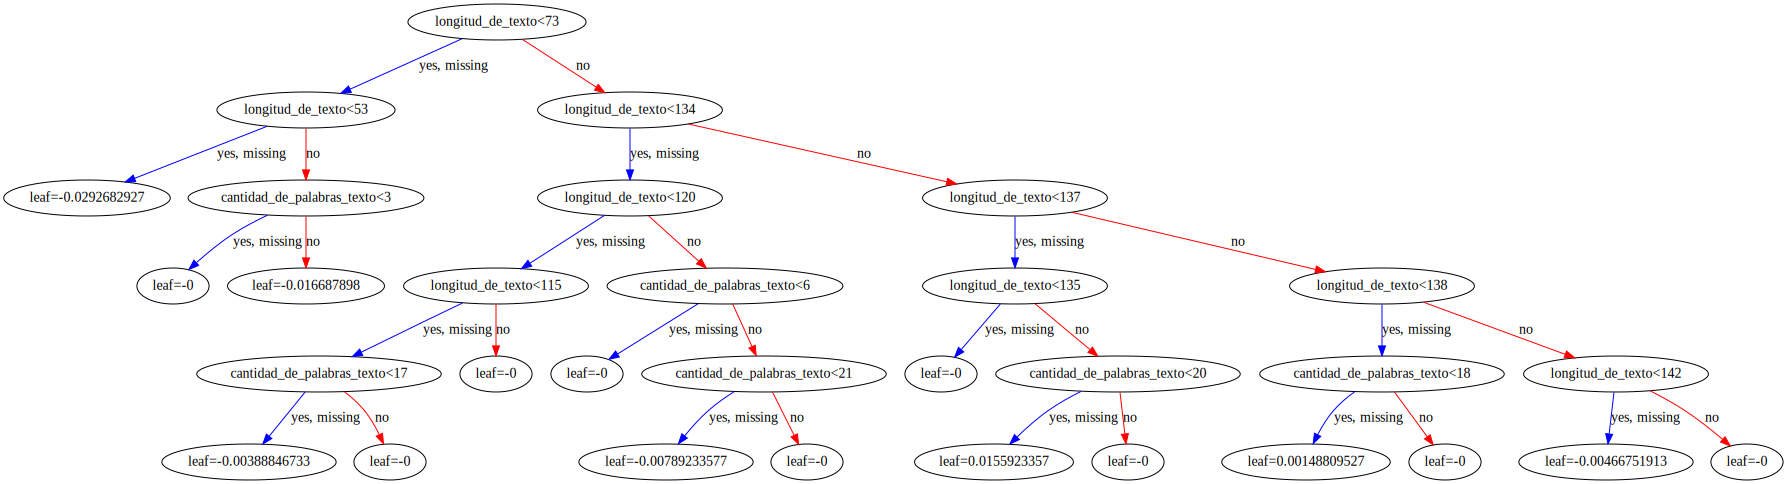

In [253]:
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
plt.rcParams['figure.figsize'] = [20, 20]
xgb.to_graphviz(xg_reg,num_trees=0)

Importancia de cada feature

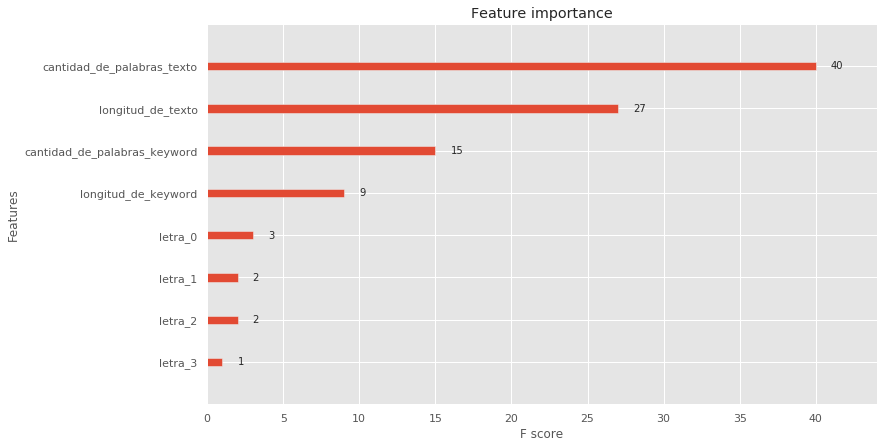

In [254]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=1, n_estimators = 20, max_features = 4)
rf.fit(train_set, train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=None, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [24]:
predicts = rf.predict(test_set).round()
result['target'] = predicts
print(F1(result))

0.5193723983349343


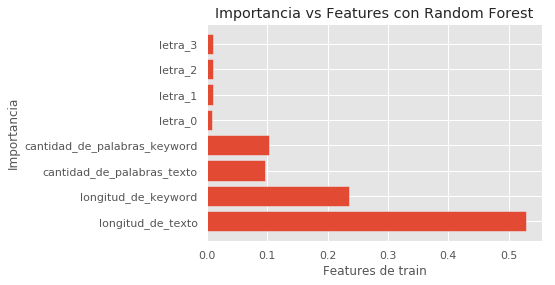

In [22]:
plt.barh(train_set.columns, rf.feature_importances_)
plt.xlabel('Features de train')
plt.ylabel('Importancia')
plt.title('Importancia vs Features con Random Forest')
plt.show()

## ENTREGA

In [ ]:
#cuando todo termina el archivo de entrega
resultados_de_prediccion.to_csv('submit.csv', index=False)